
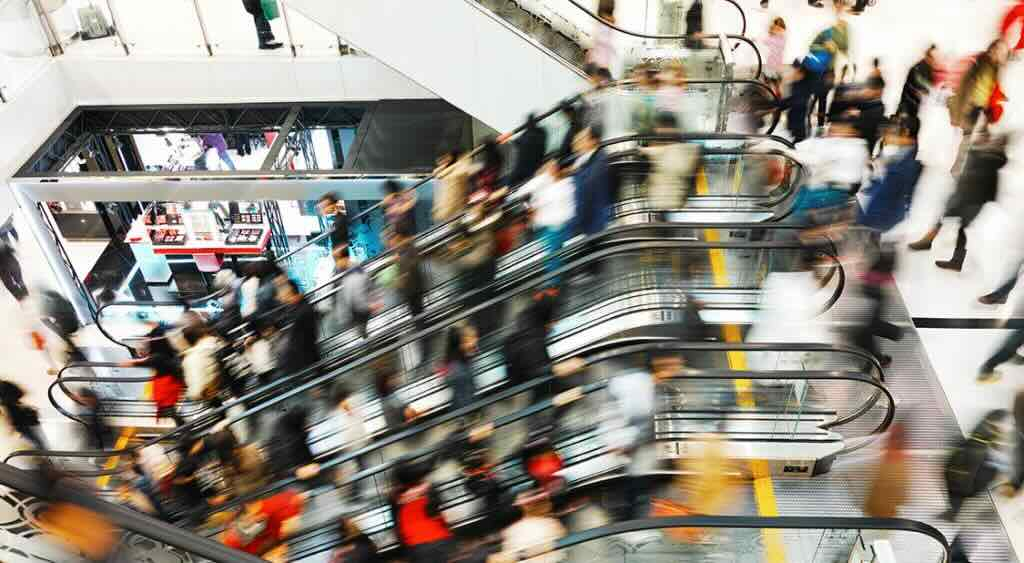

**In this notebook I will segment mall customers in different categories based on their age, annual income and spending habits.**

This kind of analyses can be useful to mall and shop owners or managers to target the most important or frequent client classes. For example, kids or young adults are expected to spend their money in videogames, sports apparel or fast fashion. Older customers may spend their money on food experiences, travel agencies and similar stuff. Clearly, the customers' choices strongly depend on their budget as well.

---
### SUMMARY

1. [Read the Data](#1)
2. [Exploratory Data Analysis](#2)
3. [KMeans Clustering](#3)
4. [Hyerarchical Clustering](#4)
5. [Customer Personas](#5)
6. [KMeans Model Predictions](#6)

---

# 1. Read the Data
<a id="1"></a>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import figure_factory as FF
from plotly.offline import iplot

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
from sklearn.metrics import silhouette_score,davies_bouldin_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn import preprocessing,cluster

from scipy.stats import kurtosis,skew,pearsonr
from scipy.cluster.hierarchy import linkage, dendrogram

from yellowbrick.cluster import KElbowVisualizer

from collections import Counter

from warnings import simplefilter
simplefilter("ignore")

In [2]:
data = pd.read_csv("Mall_Customers.csv")

data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


**Null and Duplicate Values**

In [3]:
print(f'There are {data.isnull().sum().sum()} null values in the dataset.')

There are 0 null values in the dataset.


In [4]:
print(f'There are {data.duplicated().sum()} duplicate rows in the dataset.')

There are 0 duplicate rows in the dataset.


In [5]:
print(f'The dataset has {data.shape[1]} columns and {data.shape[0]} rows.')

The dataset has 5 columns and 200 rows.


In [6]:
data.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

All the columns are numeric, except 'Gender'.

**Basic Statistics**

This is important to find out whether there are possible outliers and/or anomalous values.

In [7]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


The values above are reasonable:
* Minimum age = 18; maximum age = 70
* Min income = 15k$\$$; max income = 137k$\$$
* Min spending score = 1; max spending score = 99

**Outliers**

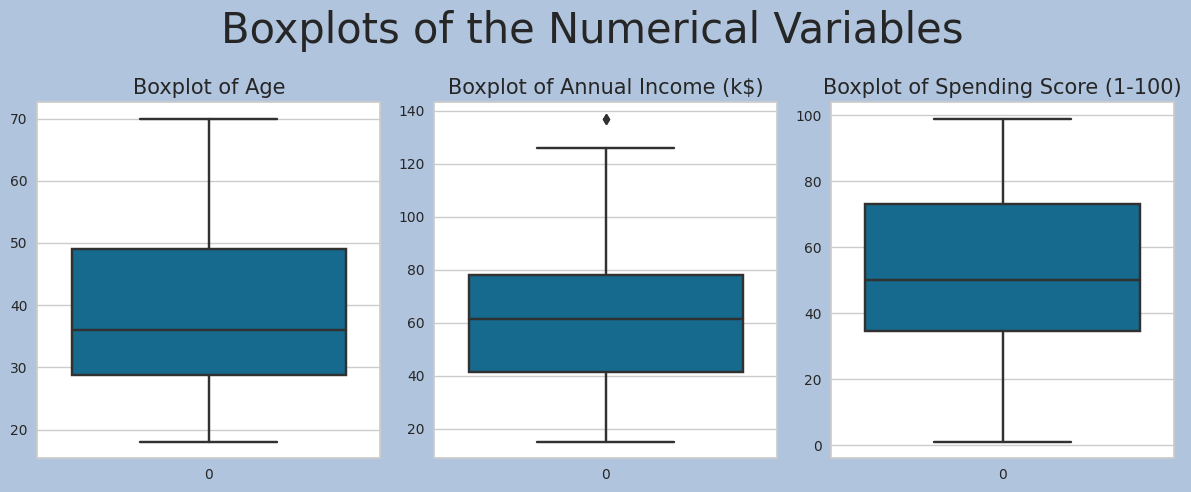

In [8]:
features = ['Age','Annual Income (k$)','Spending Score (1-100)']

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,5))

ax1 = sns.boxplot(data[features[0]],ax=ax1)
ax1.set_title('Boxplot of '+str(features[0]),fontsize=15)

ax2 = sns.boxplot(data[features[1]],ax=ax2)
ax2.set_title('Boxplot of '+str(features[1]),fontsize=15)

ax3 = sns.boxplot(data[features[2]],ax=ax3)
ax3.set_title('Boxplot of '+str(features[2]),fontsize=15)

fig.suptitle("Boxplots of the Numerical Variables",fontsize=30)    

plt.tight_layout()
fig.set_facecolor('lightsteelblue')

In [9]:
outliers_perc = []

for k,v in data[features].items():
    # Column must be of numeric type (not object)
    if data[k].dtype != 'O':
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
        out_tuple = (k,int(perc))
        outliers_perc.append(out_tuple)
        print("Column %s outliers = %.2f%%" % (k,perc))

Column Age outliers = 0.00%
Column Annual Income (k$) outliers = 1.00%
Column Spending Score (1-100) outliers = 0.00%


There is only an outlier, but it is not a 'far' one. It does not have to be taken care of.

# 2. Exploratory Data Analysis
<a id="2"></a>

I am calculating the skewness and kurtosis of the numerical distributions.

In [10]:
num_features = ['Age','Annual Income (k$)','Spending Score (1-100)']

for col in num_features:

    print(f"Skewness of {col}: {skew(data[col])}")
    print(f"Kurtosis of {col}: {kurtosis(data[col])}")
    print()

Skewness of Age: 0.48191947090957177
Kurtosis of Age: -0.6847513947723236

Skewness of Annual Income (k$): 0.319423684276314
Kurtosis of Annual Income (k$): -0.1258928297475106

Skewness of Spending Score (1-100): -0.04686530945553505
Kurtosis of Spending Score (1-100): -0.8359582718737237



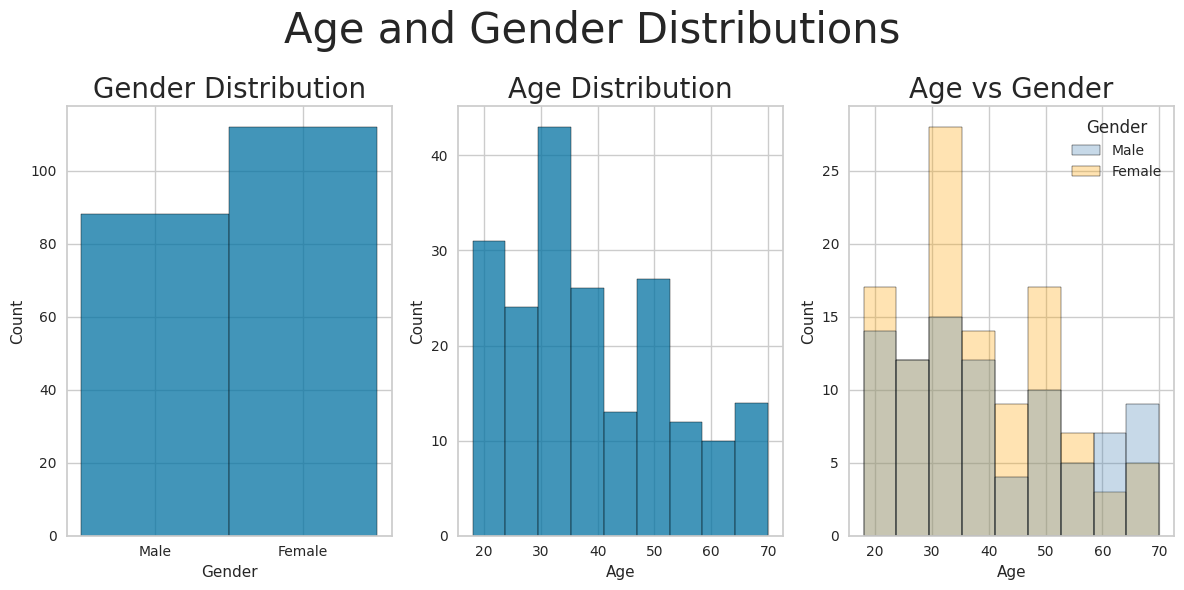

In [11]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))

ax1 = sns.histplot(data=data,x='Gender',ax=ax1)
ax1.set_title('Gender Distribution',size=20)

ax2 = sns.histplot(data=data,x='Age',ax=ax2)
ax2.set_title('Age Distribution',size=20)

ax3 = sns.histplot(data=data,x='Age',hue='Gender',palette=['steelblue','orange'],alpha=0.3,ax=ax3)
ax3.set_title('Age vs Gender',size=20)

plt.suptitle('Age and Gender Distributions',size=30)

plt.tight_layout()

In [12]:
print(f"Females: {data['Gender'].value_counts()[0] / len(data) * 100:.0f}% \
      Males: {data['Gender'].value_counts()[1] / len(data) * 100:.0f}%")

Females: 56%       Males: 44%


In [13]:
print(f"Average age = {data['Age'].mean():.0f} +/- {data['Age'].std():.0f}")

print(f"Average age females = {data.loc[data.Gender == 'Female']['Age'].mean():.0f} +/- {data.loc[data.Gender == 'Female']['Age'].std():.0f}")

print(f"Average age males = {data.loc[data.Gender == 'Male']['Age'].mean():.0f} +/- {data.loc[data.Gender == 'Male']['Age'].std():.0f}")

Average age = 39 +/- 14
Average age females = 38 +/- 13
Average age males = 40 +/- 16


One can notice that:
* There are more females than males.
* The age distribution has a moderate right (or positive) skewness. The kurtosis is < 0: the distribution is relatively 'flat', with short tails.
* The average age of customers is 39. Even though male and female customers have basically the same age, there is an excess of above 60 years old male customers. There is also an excess of between 30 and 35 y.o. female customers.

Before having a look at the income distribution, I am binning the customers' age.

In [14]:
###########################################
age_bins = [18,31,44,57,74]
age_labels = [f"{i}-{i+14}" for i in range(18,74,14)]
data['ageGroups'] = pd.cut(data['Age'],bins=age_bins,labels=age_labels,right=False)
###########################################

data['ageGroups'].value_counts()

ageGroups
32-46    67
18-32    62
46-60    43
60-74    28
Name: count, dtype: int64

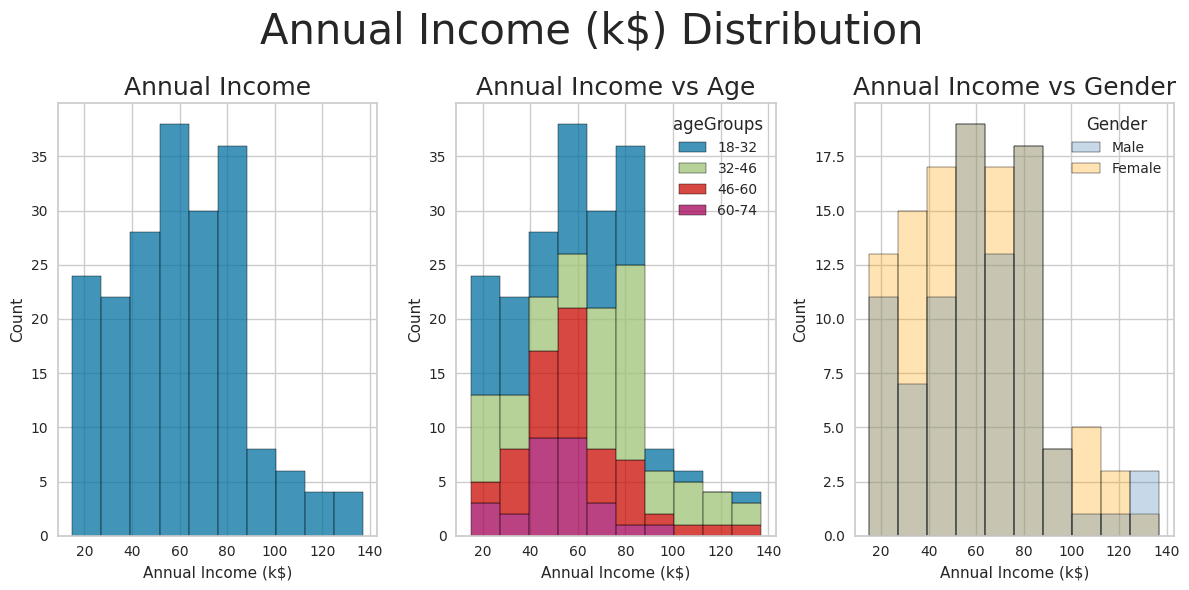

In [15]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))

ax1 = sns.histplot(data=data,x='Annual Income (k$)',ax=ax1)
ax1.set_title('Annual Income',size=18)

ax2 = sns.histplot(data=data,x='Annual Income (k$)',hue='ageGroups',multiple="stack",ax=ax2)
ax2.set_title('Annual Income vs Age',size=18)

ax3 = sns.histplot(data=data,x='Annual Income (k$)',hue='Gender',palette=['steelblue','orange'],alpha=0.3,ax=ax3)
ax3.set_title('Annual Income vs Gender',size=18)

plt.suptitle('Annual Income (k$) Distribution',size=30)

plt.tight_layout()

In [16]:
data.groupby('ageGroups')['Annual Income (k$)'].mean()

ageGroups
18-32    55.209677
32-46    69.208955
46-60    59.860465
60-74    52.785714
Name: Annual Income (k$), dtype: float64

One can notice that:
* The annual income distribution is moderately right skewed.
* The highest-earning group is that of customers aged between 32 and 46. The lowest-earning groups are those with ages between 60-74 and between 18-32. 
* The tail of the income distribution contains those that are expected to be the most valuable customers. The majority of them is aged between 32 and 46.
* I would not say that the customers of a particular gender earn significantly more than those of the other.

<Figure size 1200x600 with 0 Axes>

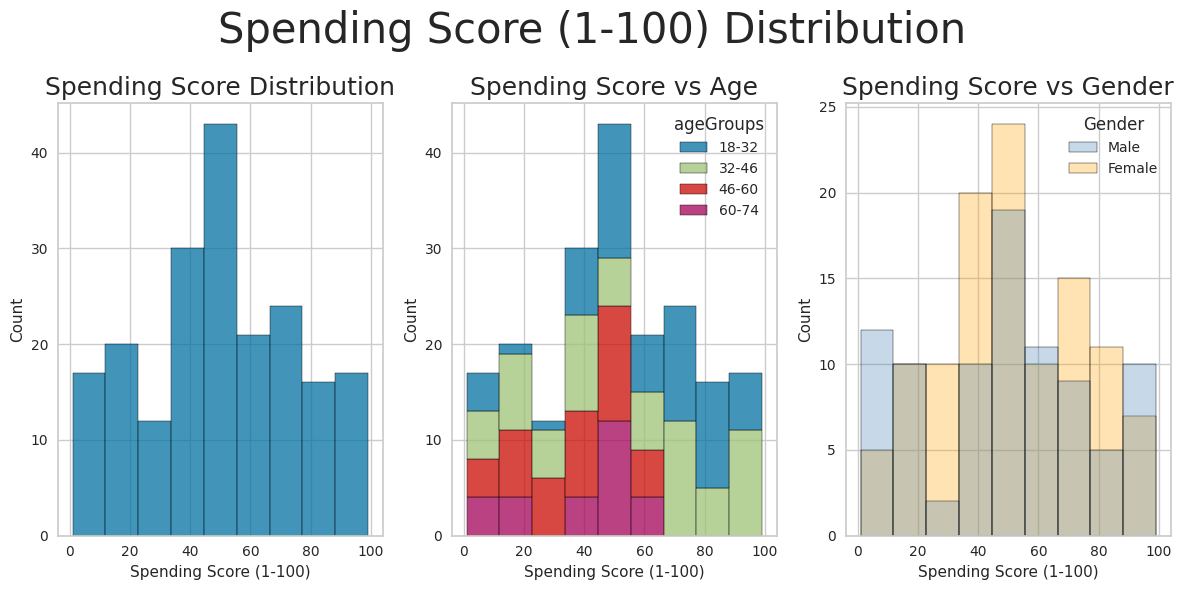

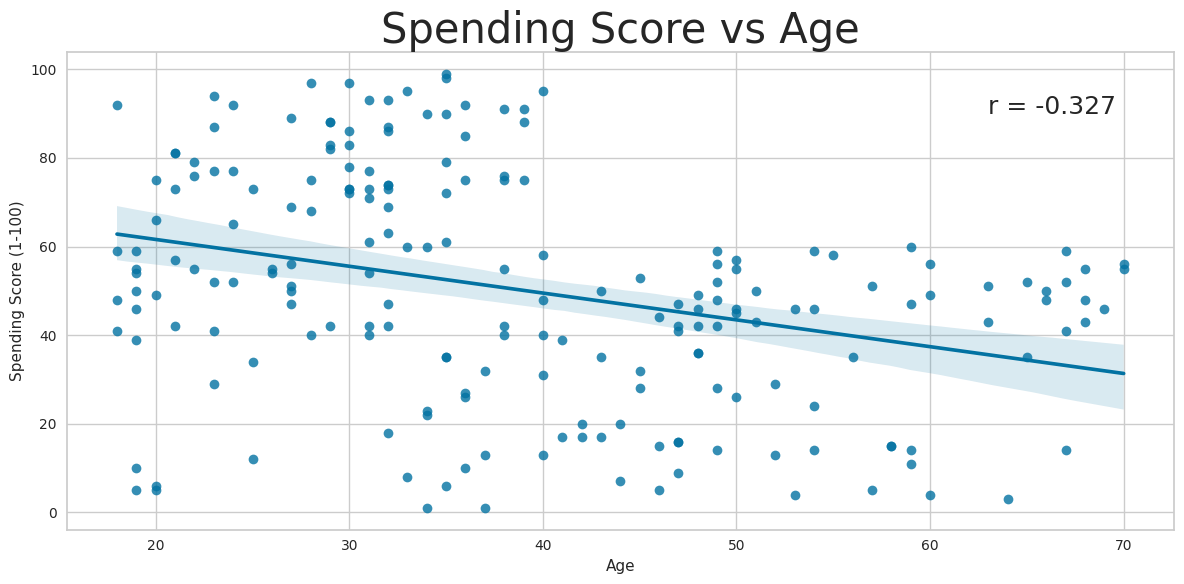

In [17]:
### Correlation: Spending Score vs Age ###

# Convert dataframe into series
list1 = data['Age']
list2 = data['Spending Score (1-100)']

# Apply the pearsonr()
corr, _ = pearsonr(list1,list2)


fig = plt.figure(figsize=(12,6))
(topfig,bottomfig) = fig.subfigures(2,1)

topfig.subplots_adjust(left=.1,right=.9,wspace=.1,hspace=.1)

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))

ax1 = sns.histplot(data=data,x='Spending Score (1-100)',ax=ax1)
ax1.set_title('Spending Score Distribution',size=18)

ax2 = sns.histplot(data=data,x='Spending Score (1-100)',hue='ageGroups',multiple="stack",ax=ax2)
ax2.set_title('Spending Score vs Age',size=18)

ax3 = sns.histplot(data=data,x='Spending Score (1-100)',hue='Gender',palette=['steelblue','orange'],alpha=0.3,ax=ax3)
ax3.set_title('Spending Score vs Gender',size=18)

plt.suptitle('Spending Score (1-100) Distribution',size=30)

plt.tight_layout()

bottomfig.subplots_adjust(left=.1,right=.9,wspace=.1,hspace=.1)

ax = plt.figure(figsize=(12,6))

ax = sns.regplot(data=data,x='Age',y='Spending Score (1-100)')
ax.set_title('Spending Score vs Age',size=30)
ax.text(63,90,f"r = {corr:.3f}",size=18)

plt.tight_layout()

In [18]:
data.groupby('ageGroups')['Spending Score (1-100)'].mean()

ageGroups
18-32    61.032258
32-46    54.402985
46-60    35.651163
60-74    38.500000
Name: Spending Score (1-100), dtype: float64

In [19]:
data.groupby('Gender')['Spending Score (1-100)'].mean()

Gender
Female    51.526786
Male      48.511364
Name: Spending Score (1-100), dtype: float64

One can notice that:
* The spending score distribution is almost bell-shaped. It has almost zero skewness, but it has negative kurtosis (i.e. it does not have tails). 
* On average, the spending score decreases with age. The 18-32 age group has the highest average spending score, the 46-60 and 60-74 age groups have the lowest. There is indeed a negative correlation between age and spending score (with r = -0.327).
* The spending score of females is slightly larger than that of male customers.

# 3. KMeans Clustering
<a id="3"></a>

## 3.1 Data Preparation

In [20]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),ageGroups
0,1,Male,19,15,39,18-32
1,2,Male,21,15,81,18-32
2,3,Female,20,16,6,18-32
3,4,Female,23,16,77,18-32
4,5,Female,31,17,40,32-46


I am dropping the 'CustomerID' column.

In [21]:
data2 = data.drop(['CustomerID'],axis=1)

data2.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),ageGroups
0,Male,19,15,39,18-32
1,Male,21,15,81,18-32
2,Female,20,16,6,18-32
3,Female,23,16,77,18-32
4,Female,31,17,40,32-46


Then, I am encoding the 'Gender' variable.

In [22]:
encoder = LabelEncoder()

data2['Gender'] = encoder.fit_transform(data2['Gender'])

data2.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),ageGroups
0,1,19,15,39,18-32
1,1,21,15,81,18-32
2,0,20,16,6,18-32
3,0,23,16,77,18-32
4,0,31,17,40,32-46


Finally, I am standardizing the numerical features.

In [23]:
#data2_sc = data2.drop('ageGroups',axis=1)
data2_sc = data2.drop(['ageGroups','Gender'],axis=1)

scaler = StandardScaler()

scaled_columns = data2_sc.columns

data2_sc[scaled_columns] = scaler.fit_transform(data2_sc[scaled_columns])

data2_sc.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


Now, I am ready for modeling.

## 3.2 'Best' Number of Clusters

To find the 'best' number of clusters, let's start with the elbow method.

In [24]:
# Create an empty list to hold many inertia values
inertia_values = []

range_clusters = range(2,16)

# Create 2 - 15 clusters, and add the inertia scores to the list
for k in range_clusters:
    kmeans = KMeans(n_clusters=k,n_init=10,random_state=42)
    kmeans.fit(data2_sc)
    inertia_values.append(kmeans.inertia_)

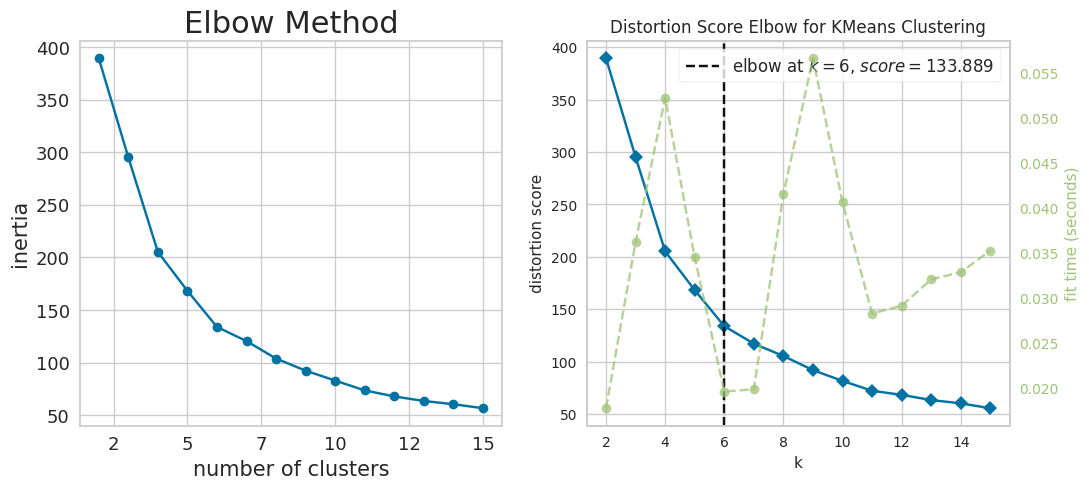

<Figure size 800x550 with 0 Axes>

In [25]:
features = data2_sc.columns

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,5))

# First Plot
ax1.plot(range_clusters,inertia_values,marker='o',linestyle='-')
ax1.xaxis.set_tick_params(labelsize=13)
ax1.set_xticklabels(ax1.get_xticks().astype(int))
ax1.yaxis.set_tick_params(labelsize=13)
ax1.set_xlabel("number of clusters",fontsize=15)
ax1.set_ylabel('inertia',fontsize=15)
ax1.set_title("Elbow Method",fontsize=22)

# Second Plot
Elbow_M = KElbowVisualizer(KMeans(),k=15)
Elbow_M.fit(data2_sc[features])
ax2 = Elbow_M.show()

plt.tight_layout() 

According to the elbow method, k = 6 is supposed to be the 'best' number of clusters. 

Let's have a look also at the Davies Bouldin score.

In [26]:
davies_bouldin_scores = []

for i in range_clusters:
    kmeans = KMeans(n_clusters=i,random_state=42)
    labels = kmeans.fit_predict(data2_sc)
    score = davies_bouldin_score(data2_sc,labels)
    davies_bouldin_scores.append(score)

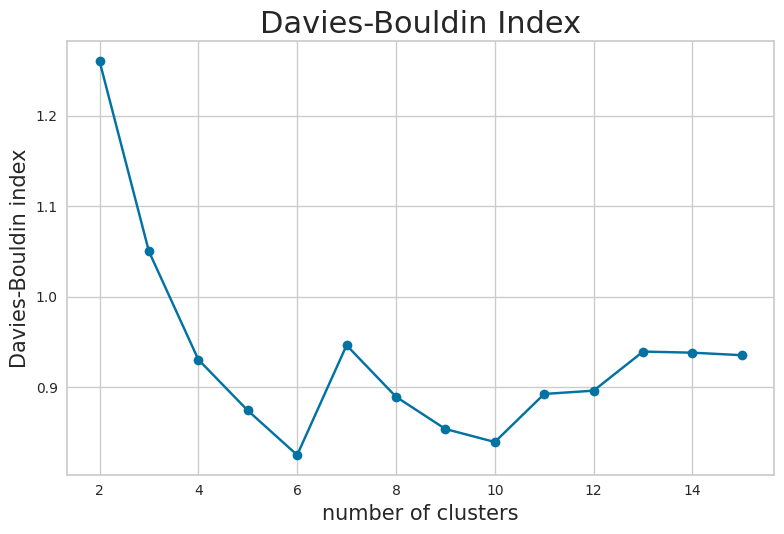

In [27]:
plt.plot(range_clusters,davies_bouldin_scores,marker='o')
plt.xlabel("number of clusters",fontsize=15)
plt.ylabel('Davies-Bouldin index',fontsize=15)
plt.title("Davies-Bouldin Index",fontsize=22)

plt.tight_layout()
plt.show()

The Davies Bouldin score analysis would suggest to consider a similar number of clusters (k = 6), or maybe k = 10.

Finally, let's have a look at the silhouette score.

In [28]:
silhouette_scores = []

for i in range_clusters:
    kmeans = KMeans(n_clusters=i,random_state=42)
    labels = kmeans.fit_predict(data2_sc) 
    score = silhouette_score(data2_sc,labels)
    silhouette_scores.append(score)

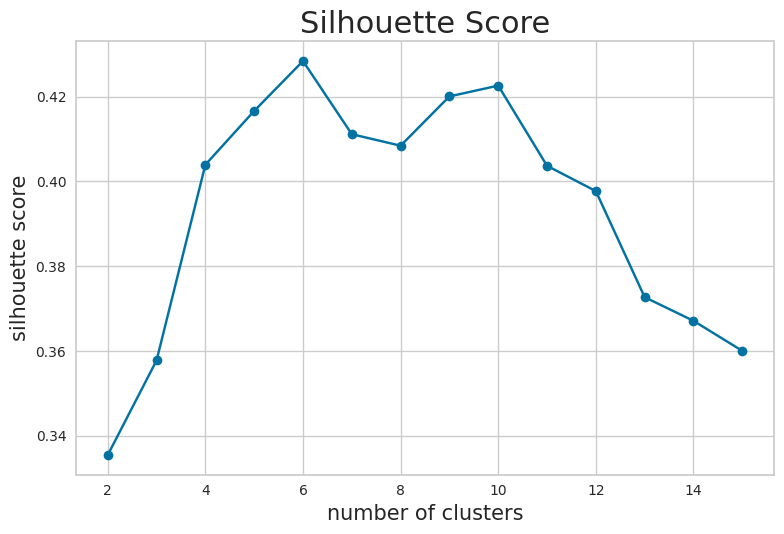

In [29]:
plt.plot(range_clusters,silhouette_scores,marker='o')
plt.xlabel("number of clusters",fontsize=15)
plt.ylabel('silhouette score',fontsize=15)
plt.title("Silhouette Score",fontsize=22)

plt.tight_layout()
plt.show()

According to the silhouette score analysis, k = 6 is a 'good' number of clusters. Also values of k of 9 and 10 are acceptable.

## 3.3 Tune the KMeans Model and Results

In order to decide what is the 'best' value of k, I will agglomerate clusters with k between 3 and 6 and then have a look at the average values of the variables in them and also at their spatial distribution. Given that I do not have so many points (they are 200), I prefer to avoid the use of higher values of k.

In [30]:
def plot_clusters(k,data2,LABELS):

    # Initiating KMeans. n_clusters = k
    km = KMeans(n_clusters=k,n_init=10,random_state=42)

    # Fit model and predict clusters
    yhat = km.fit_predict(data2[LABELS])
    data2[f"{k}_clusters_2D"] = yhat

    # Adding the Clusters feature to the dataframe before encoding and scaling
    data[f"{k}_clusters_2D"] = yhat

    # Initiating PCA to reduce dimentions to 2
    pca = PCA(n_components=2,random_state=42)

    pca.fit(data2[LABELS]) 
    data_sc_2D = pd.DataFrame(pca.transform(data2[LABELS]),columns=(["col1","col2"]))
    data_sc_2D["clusters_2D"] = yhat

    cluster_count = data_sc_2D.groupby("clusters_2D")["clusters_2D"].count().reset_index(name='count').sort_values(by='count',ascending=False)

    print(cluster_count)

    ### Figures ###
    bigfig = plt.figure(figsize=(12,6))

    (top,bottom) = bigfig.subfigures(2,1)

    ### Top figure ###
    top.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4)

    k_cluster_data = pd.DataFrame(km.cluster_centers_,columns=LABELS)

    ax = plt.figure(figsize=(12,6))
    
    ax = sns.heatmap(data=k_cluster_data,cmap='RdBu',annot=True)
    ax.set_title('Cluster Centers',fontsize=15)

    plt.suptitle(f'{k} Clusters Case',size=30)

    plt.tight_layout()

    ### Bottom figure ###
    bottom.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4)
    fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

    ax1 = sns.barplot(x='clusters_2D',y='count',data=cluster_count,palette='Spectral',ax=ax1)
    ax1.set_xlabel("cluster number",fontsize=15)
    ax1.set_ylabel('count',fontsize=15)
    ax1.set_title(f"Numerical Distribution of the Clusters",fontsize=15)

    ax2 = sns.scatterplot(x="col1",y="col2",data=data_sc_2D,hue="clusters_2D",palette='Spectral',ax=ax2)
    ax2.set_title("2D Representation of the Clusters",fontsize=15)
    legend_handles,_ = ax2.get_legend_handles_labels()

    plt.tight_layout()

Below, I am plotting the cluster distribution for several values of k.

**k = 3 Case**

I will start with the k = 3 case.

   clusters_2D  count
2            2     91
0            0     68
1            1     41


<Figure size 1200x600 with 0 Axes>

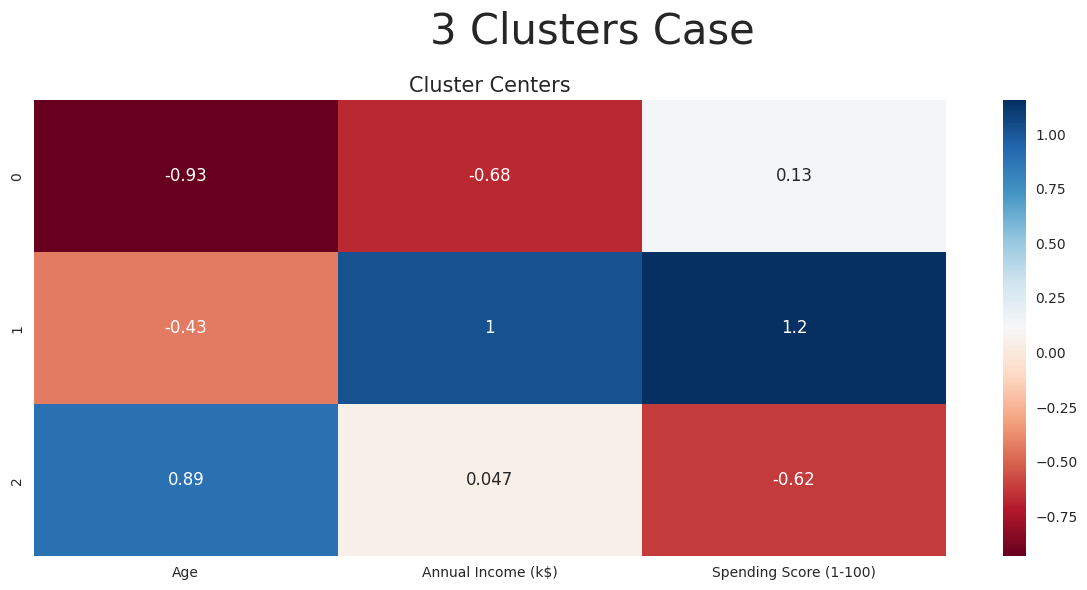

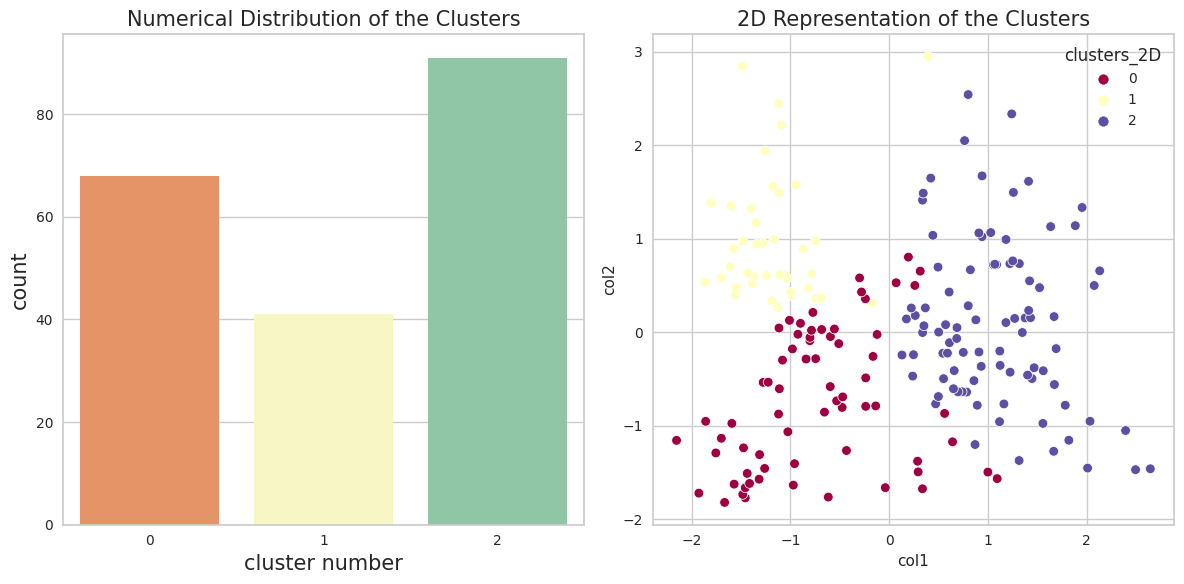

In [31]:
#LABELS2 = ['Gender','Age','Annual Income (k$)','Spending Score (1-100)']
LABELS2 = ['Age','Annual Income (k$)','Spending Score (1-100)']

plot_clusters(3,data2_sc,LABELS2)

These three clusters can be interpreted as:
* **Cluster 0:** Youngsters with low income and average spending score.
* **Cluster 1:** Young people (around 30-35-40 y.o.) with high income and high spending score.
* **Cluster 2:** Old people with average income and low spending score.

**k = 4 Case**

   clusters_2D  count
3            3     65
2            2     57
1            1     40
0            0     38


<Figure size 1200x600 with 0 Axes>

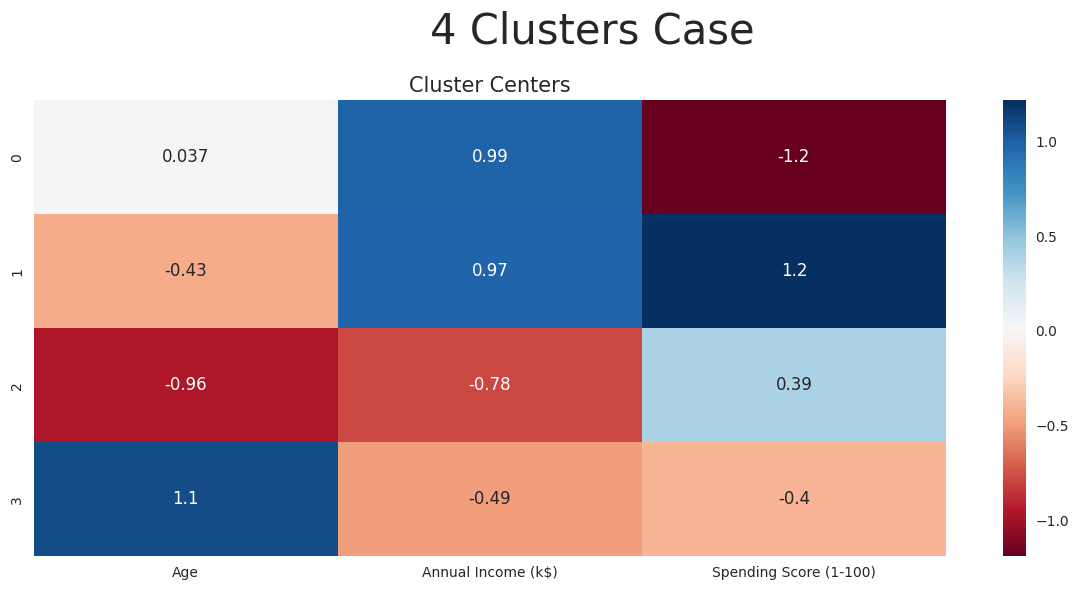

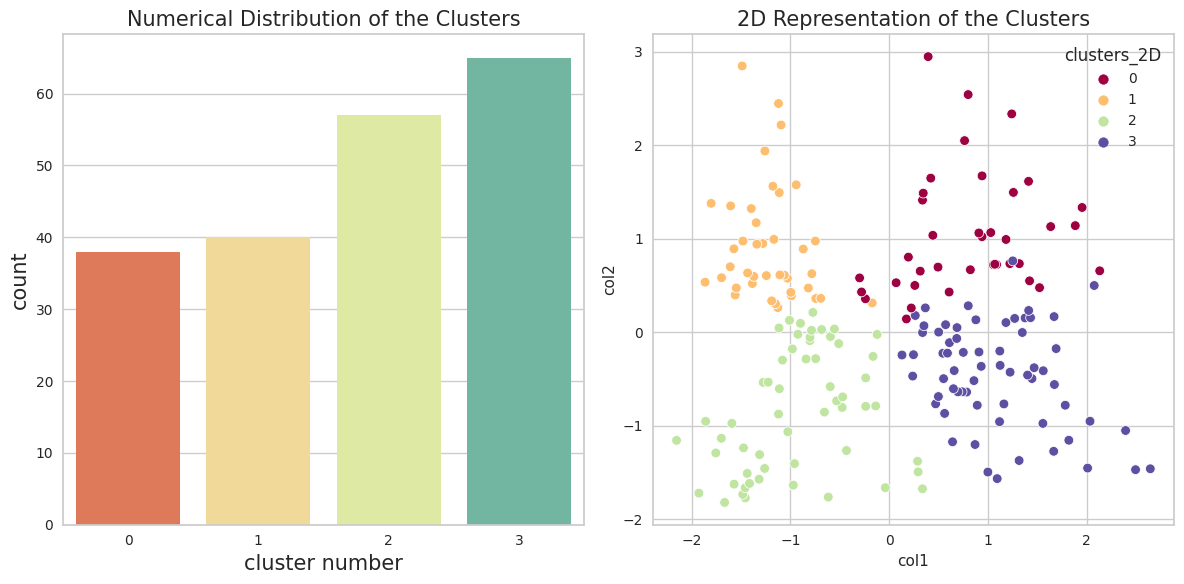

In [32]:
plot_clusters(4,data2_sc,LABELS2)

These four clusters can be interpreted as:
* **Cluster 0:** 35-45 y.o. people with high income and very low spending score.
* **Cluster 1:** 30-35 y.o. people with high income and very high spending score.
* **Cluster 2:** Youngsters with low income and medium-high spending score.
* **Cluster 3:** Old people with medium-low income and medium-low spending score.

**k = 5 Case**

   clusters_2D  count
2            2     54
0            0     47
1            1     40
4            4     39
3            3     20


<Figure size 1200x600 with 0 Axes>

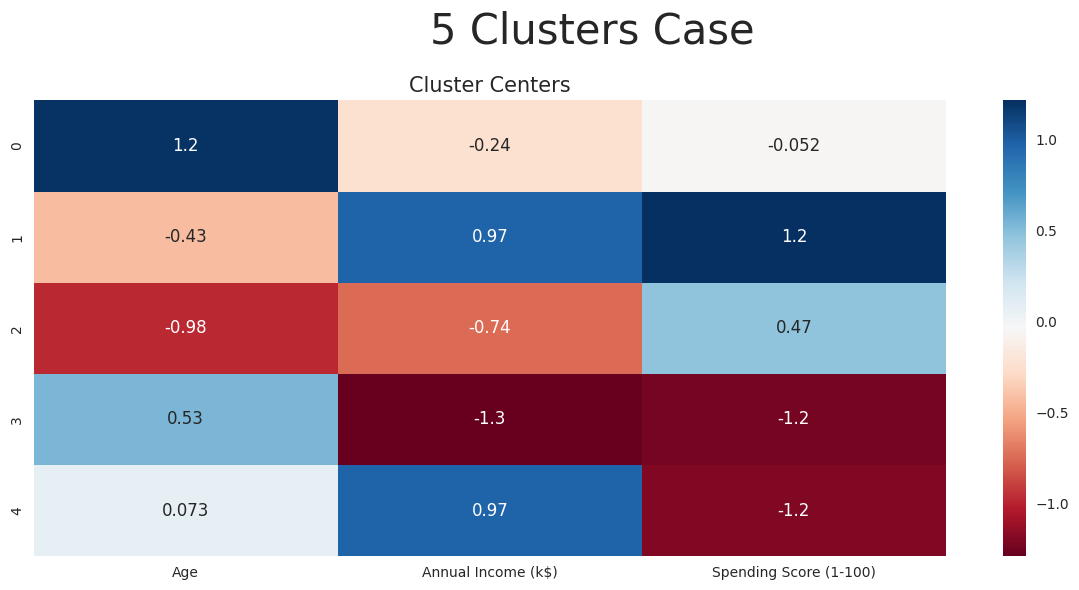

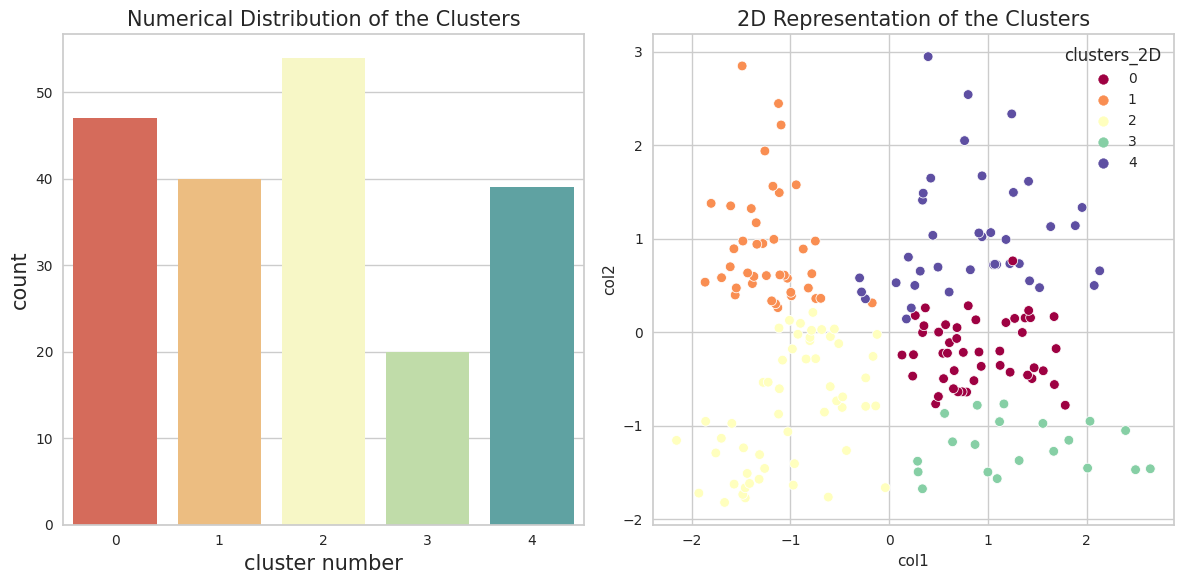

In [33]:
plot_clusters(5,data2_sc,LABELS2)

These five clusters can be interpreted as:
* **Cluster 0:** Old people with average income and average spending score.
* **Cluster 1:** 30 y.o. people with high income and very high spending score.
* **Cluster 2:** Youngsters with low income and medium-high spending score.
* **Cluster 3:** Around 50-60 y.o. people with very low income and very low spending score.
* **Cluster 4:** Around 40 y.o. people with high income and very low spending score.

**k = 6 Case**

   clusters_2D  count
1            1     45
3            3     39
4            4     39
2            2     33
0            0     23
5            5     21


<Figure size 1200x600 with 0 Axes>

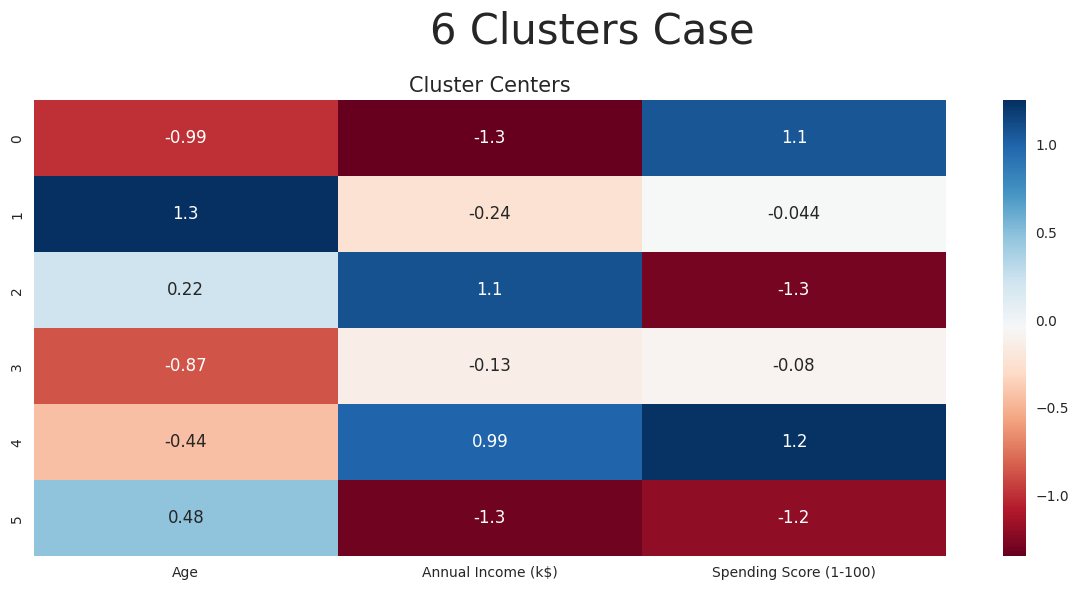

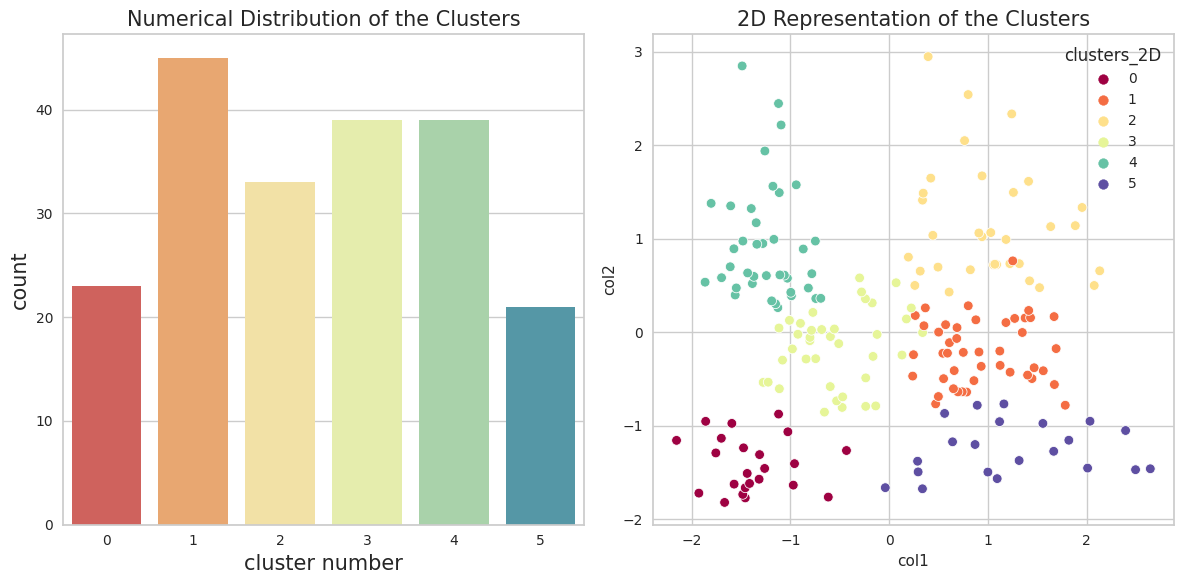

In [34]:
plot_clusters(6,data2_sc,LABELS2)

These six clusters can be interpreted as:
* **Cluster 0:** Youngsters with very low income and very high spending score.
* **Cluster 1:** Old people with average income and average spending score.
* **Cluster 2:** 40-45 y.o. people with very high income and very low spending score.
* **Cluster 3:** Youngsters with average income and average spending score.
* **Cluster 4:** Around 30-35 y.o. people with high income and very high spending score.
* **Cluster 5:** Around 50-55 y.o. people with very low income and very low spending score.

## 3.4 Interpreting the PCA Output

I want to interpret the data by using the output of PCA (Principal Component Analysis). This is another strategy that is typically used in unsupervised learning.

In [35]:
# Initiating PCA to reduce dimentions to 2
pca = PCA(n_components=2,random_state=42)

pca.fit(data2_sc[LABELS2]) 
data2_pca = pd.DataFrame(pca.transform(data2_sc[LABELS2]),columns=(["col1","col2"]))

data2_pca.head()

,col1,col2
0,-0.615720,-1.763481
1,-1.665793,-1.820747
2,0.337862,-1.674799
3,-1.456573,-1.772430
4,-0.038465,-1.662740


In [36]:
pca.explained_variance_ratio_

array([0.44266167, 0.33308378])

The sum of the explained variance ratio components is almost 80%. This means that the columns 'col1' and 'col2' can describe almost 80% of the dataset's variance.

Then, I am having a look at the PCA components (the 'new' x and y axes) ...

In [37]:
pca.components_

array([[ 0.70638235, -0.04802398, -0.70619946],
       [ 0.03014116,  0.9988316 , -0.03777499]])

... and I am comparing them to the dataset columns before PCA (the 'old' x, y and z axes).

In [38]:
data2_sc[LABELS2].columns

Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

This is basically an eigenvalue problem. By comparing the PCA components to the dataset columns before PCA, we can interpret the first principal component, 'col1', and the second, 'col2', as follows.
* Higher values along the 'col1' axis mean older customers; lower values along 'col1' mean higher spending scores.
* Higher values along 'col2' mean higher income.

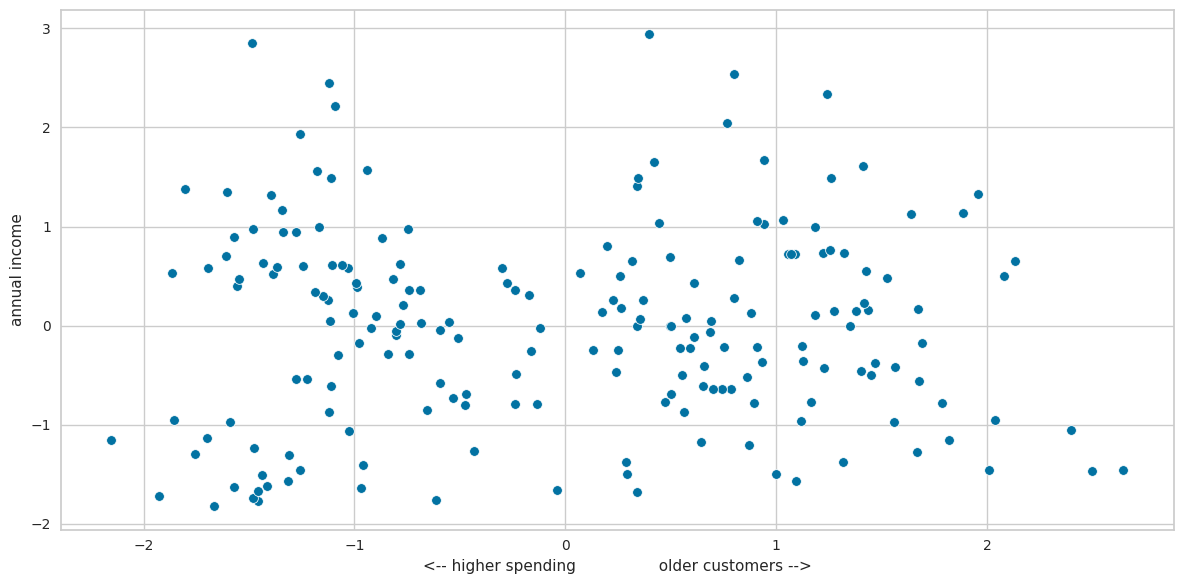

In [39]:
plt.figure(figsize=(12,6))

sns.scatterplot(x='col1',y='col2',data=data2_pca)

plt.xlabel('<-- higher spending                 older customers -->')
plt.ylabel('annual income')

plt.tight_layout()

The PCA results would indicate that the highest spenders are generally young or relatively young. Moreover, it seems that there is no correlation between spending rate and income. This is in accordance with the results of the previous cluster analysis. 

Let's find out if similar conclusions can be drawn by studying the correlation heatmap of the dataset before PCA.

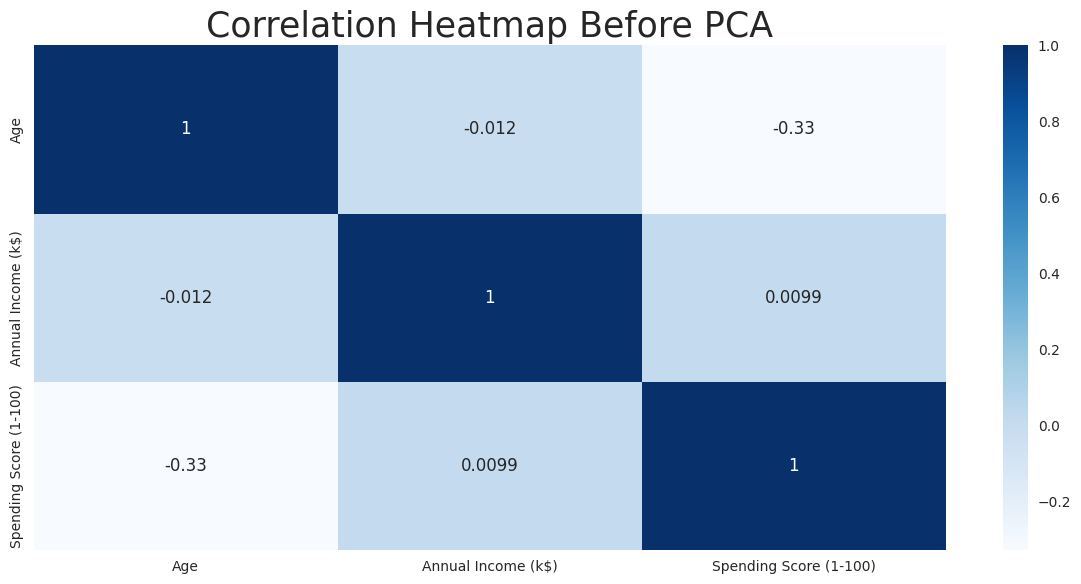

In [40]:
# Create correlation heatmap
plt.figure(figsize=(12,6))
sns.heatmap(data2_sc[['Age','Annual Income (k$)','Spending Score (1-100)']].corr(method='pearson'),annot=True,cmap='Blues')
plt.title('Correlation Heatmap Before PCA',fontsize=25)

plt.tight_layout()
plt.show()

This heatmap shows that there is almost no correlation between the annual income and age/spending and that there is a medium-sized negative correlation between the customer's age and his/her spending score.

# 4. Hyerarchical Clustering
<a id="4"></a>

I am creating a dendrogram using the three fields of the scaled data set.

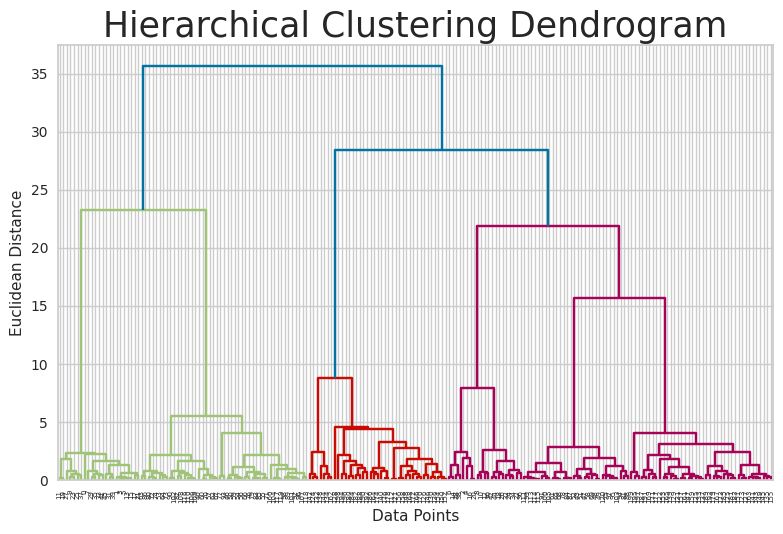

In [41]:
data3_sc = data2_sc.drop(['3_clusters_2D','4_clusters_2D','5_clusters_2D','6_clusters_2D'],axis=1)

linkage_matrix = linkage(data2_sc,method='ward')
dendrogram_info = dendrogram(linkage_matrix)

plt.title("Hierarchical Clustering Dendrogram",size=25)
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")

plt.tight_layout()

According to the dendrogram, the 'best' number of clusters is between 3 and 6.

I am plotting the same dendrogram by setting the threshold at an Euclidean distance of 20: as a result, I will have 5 different colors (and 5 clusters).

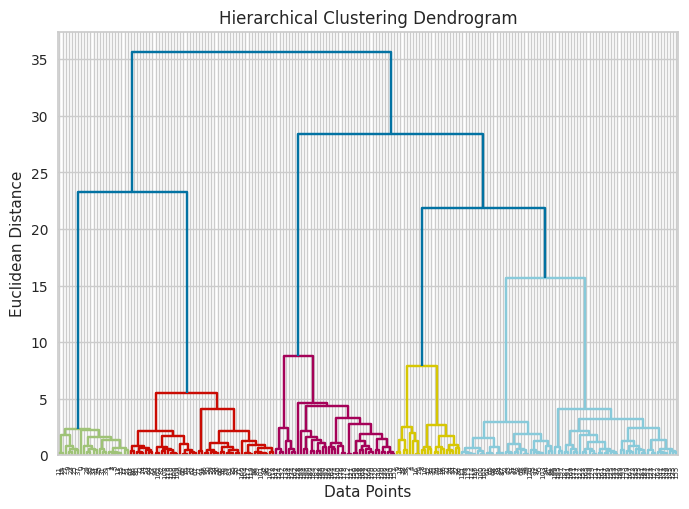

In [42]:
# Visually identify the ”best” number of clusters and adjust the color_threshold
linkage_matrix = linkage(data2_sc,method='ward')
dendrogram_info = dendrogram(linkage_matrix,color_threshold=20)

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance");

## 4.1 k = 4 Case

The first case that I want to explore is k = 4.

I am creating a cluster map.

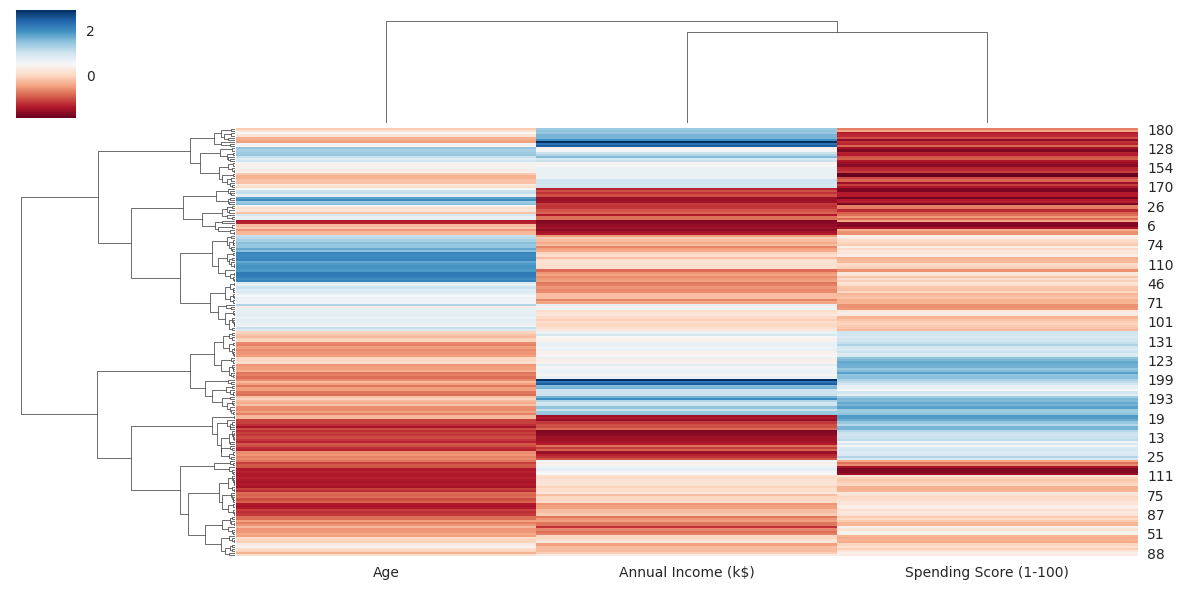

In [43]:
# create a cluster map
clustermap = sns.clustermap(data3_sc,method='ward',cmap='RdBu',figsize=(12,6),xticklabels=data3_sc.columns)
plt.show()

One can identify the clusters by looking at the left side of the plot and see where the lines split. The four clusters case is relatively easy to read: one has to look for the leftmost 4 line split. After identifying the four clusters, their properties can be determined by 'averaging' the colors in the corresponding cluster areas on the right of the plot.

Let's take the age column. The first cluster ('cluster 0') is predominantly white (white, orange and sky blue): this means average age. The second cluster is predominantly blue and light blue: this means middle-aged to old customers. The third cluster is orange: this means young or relatively young customers. The fourth cluster is red: this means very young customers.

I can interpret the results as follows:
* **Cluster 0:** Average age, average to high annual income, low spending score.
* **Cluster 1:** Older people, medium to low annual income, medium to low spending score.
* **Cluster 2:** Relatively young people, medium to high annual income, high spending score.
* **Cluster 3:** Young people, low annual income, average spending score.

I want to compare this hyerarchical model interpretation (k = 4) to that of KMeans for k = 4 from before.

* **Cluster 0:** 35-45 y.o. people with high income and very low spending score --> **Cluster 0** of the hyerarchical model
* **Cluster 1:** 30-35 y.o. people with high income and very high spending score --> **Cluster 2** of the hyerarchical model
* **Cluster 2:** Youngsters with low income and medium-high spending score --> **Cluster 3** of the hyerarchical model
* **Cluster 3:** Old people with medium-low income and medium-low spending score --> **Cluster 1** of the hyerarchical model

One can notice that there is a good correspondence between the KMeans and hyerarchical model interpretations.

Finally, let's have a look at the classes and their count in the k = 4 case and also at the silhouette score.

In [44]:
agg_4Cl = AgglomerativeClustering(4)
agg_4Cl.fit(data3_sc)

print(Counter(agg_4Cl.labels_))

silhouette_score(data3_sc,agg_4Cl.labels_)

Counter({0: 67, 1: 66, 2: 39, 3: 28})


0.3614512741691407

## 4.2 k = 5 Case

In [45]:
# hierarchical clustering with sklearn, with 5 clusters
agg = AgglomerativeClustering(5)
agg.fit(data3_sc)

print(Counter(agg.labels_))

Counter({0: 66, 1: 45, 2: 39, 3: 28, 4: 22})


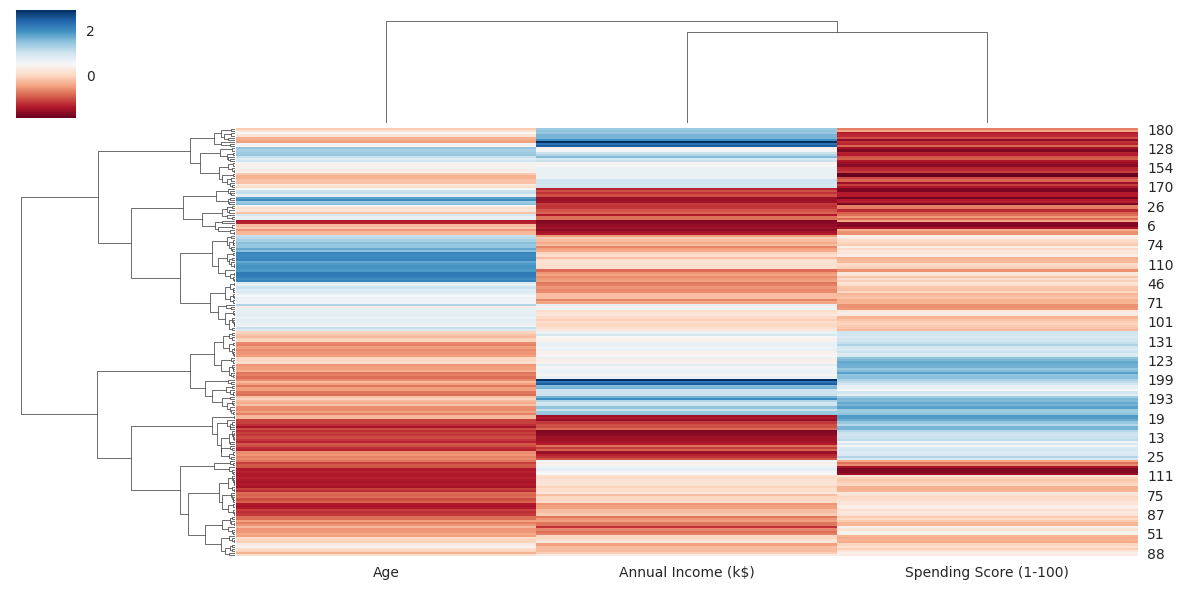

In [46]:
# create a cluster map
clustermap = sns.clustermap(data3_sc,method='ward',cmap='RdBu',figsize=(12,6),xticklabels=data3_sc.columns)
plt.show()

I am not providing a cluster classification for this case because it is more difficult to identify the hierarchy and read where the lines split on the left of the plot.

In [47]:
agg_5Cl = AgglomerativeClustering(5)
agg_5Cl.fit(data3_sc)

print(Counter(agg_5Cl.labels_))

silhouette_score(data3_sc,agg_5Cl.labels_)

Counter({0: 66, 1: 45, 2: 39, 3: 28, 4: 22})


0.39002826186267214

## 4.3 k = 6 Case

In [48]:
# hierarchical clustering with sklearn, with 6 clusters
agg = AgglomerativeClustering(6)
agg.fit(data3_sc)

print(Counter(agg.labels_))

Counter({0: 45, 1: 45, 2: 39, 3: 28, 4: 22, 5: 21})


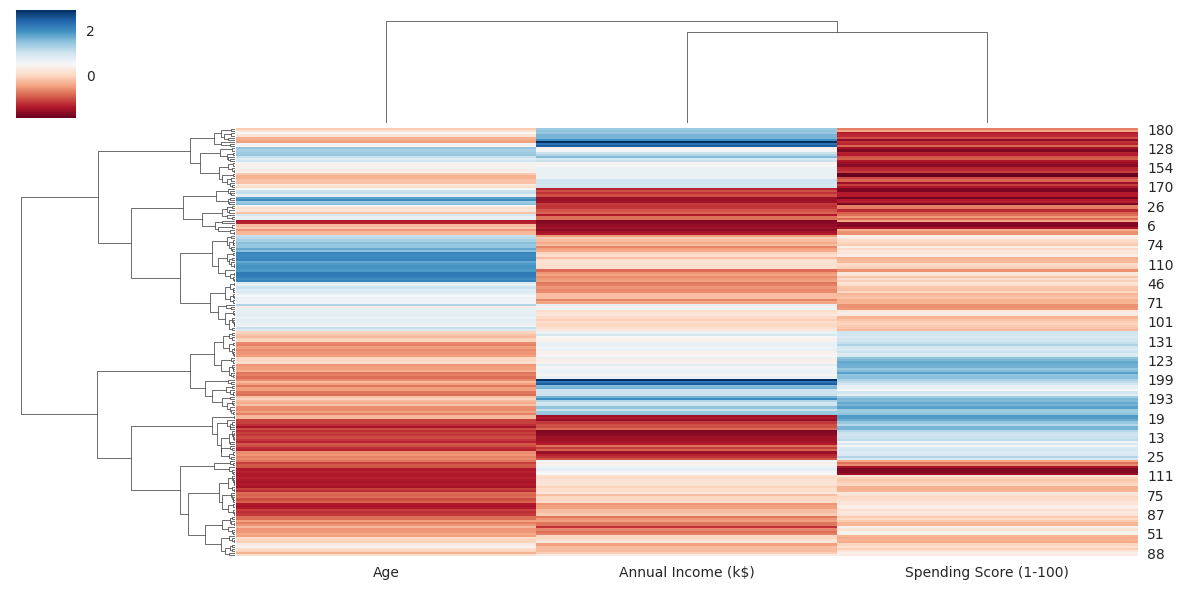

In [49]:
# create a cluster map
clustermap = sns.clustermap(data3_sc,method='ward',cmap='RdBu',figsize=(12,6),xticklabels=data3_sc.columns)
plt.show()

In the k = 6 case we have:
* **Cluster 0:** Average age, medium-high annual income, very low spending score.
* **Cluster 1:** Average age, very low annual income, very low spending score.
* **Cluster 2:** Old people, medium-low annual income, medium-low spending score.
* **Cluster 3:** Young people, medium-high annual income, medium-high spending score.
* **Cluster 4:** Very young people, very low annual income, medium-high spending score.
* **Cluster 5:** Young people, average annual income, average spending score.


This classification can be compared to that of the KMeans model for k = 6.

* **Cluster 0:** Youngsters with very low income and very high spending score --> **Cluster 4** of the hyerarchical model
* **Cluster 1:** Old people with average income and average spending score --> **Cluster 2** of the hyerarchical model
* **Cluster 2:** 40-45 y.o. people with very high income and very low spending score --> **Cluster 0** of the hyerarchical model
* **Cluster 3:** Youngsters with average income and average spending score --> **Cluster 5** of the hyerarchical model
* **Cluster 4:** Around 30-35 y.o. people with high income and very high spending score --> **Cluster 3** of the hyerarchical model
* **Cluster 5:** Around 50-55 y.o. people with very low income and very low spending score --> **Cluster 1** of the hyerarchical model

As in the k = 4 case, there is also a good correspondence between the KMeans and hyerarchical model interpretations for k = 6.

In [50]:
agg_6Cl = AgglomerativeClustering(6)
agg_6Cl.fit(data3_sc)

print(Counter(agg_6Cl.labels_))

silhouette_score(data3_sc,agg_6Cl.labels_)

Counter({0: 45, 1: 45, 2: 39, 3: 28, 4: 22, 5: 21})


0.4201169558789579

**The k = 6 case in the hyerarchical model is that with the highest silhouette score. The same holds for the KMeans model, where the 'best' value of k is 6.**

**This is why I expect the 'best' number of clusters to be k = 6.**

# 5. Customer Personas
<a id="5"></a>

I will consider the k = 6 interpretation and create customer personas based on those findings.

In [51]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),ageGroups,3_clusters_2D,4_clusters_2D,5_clusters_2D,6_clusters_2D
0,1,Male,19,15,39,18-32,0,2,2,0
1,2,Male,21,15,81,18-32,0,2,2,0
2,3,Female,20,16,6,18-32,0,2,3,5
3,4,Female,23,16,77,18-32,0,2,2,0
4,5,Female,31,17,40,32-46,0,2,2,5


To do this, I am calculating the average value (or mode) of the features in each cluster. These average values will basically 'create' my customer personas. I will just have to pick a name for each one of them.

In [52]:
data.groupby('6_clusters_2D').agg(gender=('Gender',lambda x: x.value_counts().index[0]),
                       age=('Age','mean'),
                       income=('Annual Income (k$)','mean'),
                       spending_score=('Spending Score (1-100)','mean')).reset_index()

,6_clusters_2D,gender,age,income,spending_score
0,0,Female,25.000000,25.260870,77.608696
1,1,Female,56.333333,54.266667,49.066667
2,2,Male,41.939394,88.939394,16.969697
3,3,Female,26.794872,57.102564,48.128205
4,4,Female,32.692308,86.538462,82.128205
5,5,Female,45.523810,26.285714,19.380952


In [53]:
table_data = [['Customer Persona', 'Age', 'Income', 'Spending Score (1-100)', 'Customer value'],
             ['Katie', 25, '25k$ (LOW)', '78 (HIGH)', '****'],
             ['Paula', 56, '54k$ (AVG)', '49 (AVG)', '***'],
             ['Jack', 42, '89k$ (HIGH)', '17 (LOW)', '**'],
             ['Hillary', 27, '57k$ (AVG)', '48 (AVG)', '***'],              
             ['Ally', 33, '87k$ (HIGH)', '82 (HIGH)', '*****'],              
             ['Geena', 46, '26k$ (LOW)', '19 (LOW)', '**']]

# Initialize a figure with FF.create_table(table_data)
figure = FF.create_table(table_data,height_constant=30)
figure.layout.width=1500

iplot(figure)

# 6. KMeans Model Predictions
<a id="6"></a>

I am defining two new customers.

In [54]:
ID_201 = pd.DataFrame({'CustomerID':[201],'Gender':'Female','Age':39,'Annual Income (k$)':35,'Spending Score (1-100)':45})

ID_202 = pd.DataFrame({'CustomerID':[202],'Gender':'Male','Age':29,'Annual Income (k$)':55,'Spending Score (1-100)':65})

ID_201.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,201,Female,39,35,45


In [55]:
ID_202.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,202,Male,29,55,65


Then, I am transforming the new dataframes.

In [56]:
ID_201 = ID_201.drop(['CustomerID','Gender'],axis=1)
ID_202 = ID_202.drop(['CustomerID','Gender'],axis=1)

scaled_columns = data3_sc.columns

ID_201[scaled_columns] = scaler.transform(ID_201[scaled_columns])
ID_202[scaled_columns] = scaler.transform(ID_202[scaled_columns])

Text(0.5, 1.0, 'Cluster Centers')

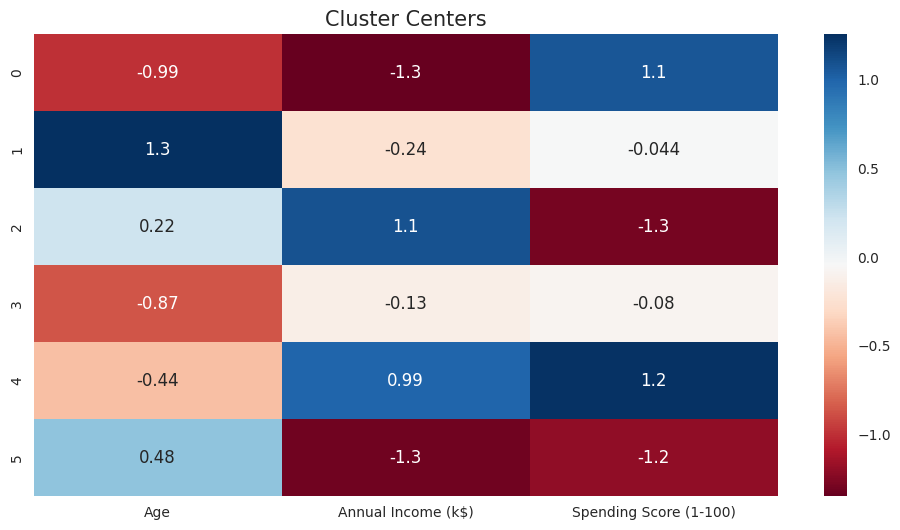

In [57]:
# Initiating KMeans. n_clusters = 6
km6 = KMeans(n_clusters=6,n_init=10,random_state=42)

# Fit model and predict clusters
yhat = km6.fit_predict(data3_sc[scaled_columns])
data3_sc[f"{k}_clusters_2D"] = yhat

# As a remainder, plot the a heatmap of the cluster centers
six_cluster_data = pd.DataFrame(km6.cluster_centers_,columns=scaled_columns)

ax = plt.figure(figsize=(12,6))
ax = sns.heatmap(data=six_cluster_data,cmap='RdBu',annot=True)
ax.set_title('Cluster Centers',fontsize=15)

The meaning of the six clusters was the following:
* **Cluster 0:** Youngsters with very low income and very high spending score.
* **Cluster 1:** Old people with average income and average spending score.
* **Cluster 2:** 40-45 y.o. people with very high income and very low spending score.
* **Cluster 3:** Youngsters with average income and average spending score.
* **Cluster 4:** Around 30-35 y.o. people with high income and very high spending score.
* **Cluster 5:** Around 50-55 y.o. people with very low income and very low spending score.

Now, I can predict which clusters the users 'ID_201' and 'ID_202' belong to.

In [58]:
km6.predict(ID_201)

array([5], dtype=int32)

In [59]:
km6.predict(ID_202)

array([3], dtype=int32)

# References

1. Jacopo Ferretti, [*EXPEDIA Travels: Clustering the Customer Bookings*](https://www.kaggle.com/code/jacopoferretti/expedia-travels-clustering-the-customer-bookings), notebook on Kaggle.
2. Jacopo Ferretti, [*SUPERSTORE: Sales Analysis & Customer Segmentation*](https://www.kaggle.com/code/jacopoferretti/superstore-sales-analysis-customer-segmentation), notebook on Kaggle.
3. Alice Zhao (Maven Analytics), *Python Data Science: Unsupervised Machine Learning*, course on Udemy.
4. Bex Tuychiev, [*Understanding Skewness And Kurtosis And How to Plot Them*](https://www.datacamp.com/tutorial/understanding-skewness-and-kurtosis), article on datacamp.com.